# Import Libraries

In [124]:
import torch, torchvision
print(torch.__version__,torch.cuda.is_available())

import mmdet
import mmcv
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
import mmocr
import matplotlib.pyplot as plt
import cv2

from imutils.object_detection import non_max_suppression
from skewness import *

from mmocr.apis import MMOCRInferencer

import cv2
from craft_text_detector import Craft
import matplotlib.pyplot as plt
import os
import pytesseract

2.0.1 True


# Fix rotation

In [125]:
ocr = MMOCRInferencer(det='TextSnake')

Loads checkpoint by http backend from path: https://download.openmmlab.com/mmocr/textdet/textsnake/textsnake_resnet50-oclip_fpn-unet_1200e_ctw1500/textsnake_resnet50-oclip_fpn-unet_1200e_ctw1500_20221101_134814-a216e5b2.pth


c:\Users\Ghost\anaconda3\envs\galli_maps\lib\site-packages\mmengine\visualization\visualizer.py:196: UserWarning: Failed to add <class 'mmengine.visualization.vis_backend.LocalVisBackend'>, please provide the `save_dir` argument.
  warnings.warn(f'Failed to add {vis_backend.__class__}, '


In [298]:
img = cv2.imread('images/up.jpg')
image = img.copy()
det = ocr(img)

Inference ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   

# Get all angled contours

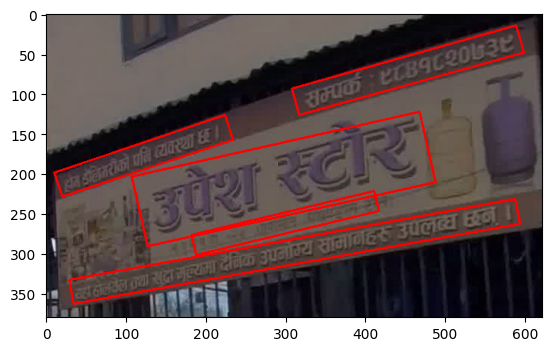

In [299]:
boxes = det['predictions'][0]['det_polygons']
angled_boxes = []
for box in boxes:
    if len(box) >= 3:  # Ensure at least 3 points for a polygon
        # Convert box points to numpy array for easier manipulation
        box_points = np.array(box, dtype=np.int32).reshape(-1, 2)

        # Calculate the minimum bounding rectangle
        rotated_rect = cv2.minAreaRect(box_points)
        box_vertices = cv2.boxPoints(rotated_rect)
        box_vertices = np.int0(box_vertices)
        angled_boxes.append(box_vertices)
        # Draw the rotated rectangle
        cv2.drawContours(img, [box_vertices], 0, (255, 0, 0), 2)

plt.imshow(img)

# Get largest contour

In [300]:
largest_contour = max(angled_boxes, key=cv2.contourArea)

# Get angle of contour wrt x axis

In [301]:
rect = cv2.minAreaRect(largest_contour)

In [302]:
largest_contour

array([[107, 204],
       [468, 123],
       [488, 211],
       [127, 291]], dtype=int64)

# Easier Way

In [303]:
center, size, angle = rect
center
size
angle

77.3536148071289

In [304]:
# Define the rectangle's corner points
rectangle_points = largest_contour
print(rectangle_points)
# Choose two points to calculate the slope
x1, y1 = rectangle_points[0]
x2, y2 = rectangle_points[1]

# Calculate the slope (tangent) of the rectangle's side with respect to the x-axis
slope = (y2 - y1) / (x2 - x1)

# Calculate the angle in degrees using the arctangent function
angle_radians = np.arctan(slope)
angle_degrees = np.degrees(angle_radians)

# Ensure the angle is positive
# if angle_degrees < 0:
    # angle_degrees += 180

print("Angle of the rectangle with respect to x-axis:", angle_degrees + 180, "degrees")

[[107 204]
 [468 123]
 [488 211]
 [127 291]]
Angle of the rectangle with respect to x-axis: 167.35361096761122 degrees


# Rotate Image

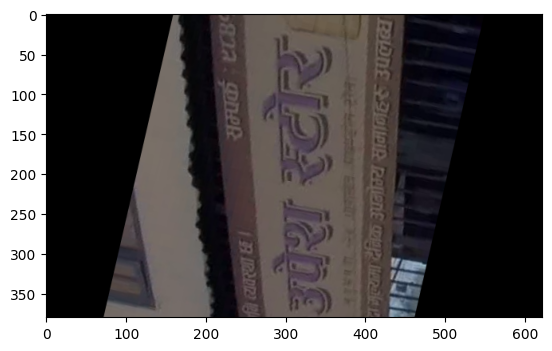

In [306]:
height, width = img.shape[:2]
center = (width // 2, height // 2)
rotation_matrix = cv2.getRotationMatrix2D(center,  77 , scale=1.0)
rotated_image = cv2.warpAffine(image, rotation_matrix, (width, height))
plt.imshow(rotated_image)

# Craft and Text Detection

In [7]:
pytesseract.pytesseract.tesseract_cmd = r'C://Program Files//Tesseract-OCR//tesseract.exe'

os.environ["TESSDATA_PREFIX"] =  "C://Program Files//Tesseract-OCR//tessdata"
custom_config = r'-c preserve_interword_spaces=5 --oem 3 --psm 8 '

In [325]:
def angle_with_x_axis(contour):
    # Extract the first and last points of the contour
    first_point = contour[0]
    last_point = contour[-1]

    # Calculate the cross product between the vector and the positive x-axis
    cross_product = np.cross(last_point, first_point)

    if cross_product > 0:
        # The contour makes a counterclockwise angle with the x-axis.
        return 0
    elif cross_product < 0:
        # The contour makes a clockwise angle with the x-axis.
        return 1
    else:
        # The contour is aligned with the x-axis.
        return None

In [334]:
class CraftModule:
    def __init__(self,craft,mmocr):
        self.craft = craft
        self.mmocr = mmocr
        self.boxes = None
        self.image = None
    
    def plot_image(self,img):
        plt.axis('off');
        plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB));
        plt.show();
    
    def angle_with_x_axis(self,contour):
        # Extract the first and last points of the contour
        first_point = contour[0]
        last_point = contour[-1]

        # Calculate the cross product between the vector and the positive x-axis
        cross_product = np.cross(last_point, first_point)

        if cross_product > 0:
            # The contour makes a counterclockwise angle with the x-axis.
            return 0
        elif cross_product < 0:
            # The contour makes a clockwise angle with the x-axis.
            return 1
        else:
            # The contour is aligned with the x-axis.
            return None

    def rotate_image(self):
        img = self.image.copy()
        det = self.mmocr(self.image)
        boxes = det['predictions'][0]['det_polygons']
        angled_boxes = []

        # Get angled boxes
        for box in boxes:
            if len(box) >= 3:  # Ensure at least 3 points for a polygon
                # Convert box points to numpy array for easier manipulation
                box_points = np.array(box, dtype=np.int32).reshape(-1, 2)

                # Calculate the minimum bounding rectangle
                rotated_rect = cv2.minAreaRect(box_points)
                box_vertices = cv2.boxPoints(rotated_rect)
                box_vertices = np.int0(box_vertices)
                angled_boxes.append(box_vertices)
                cv2.drawContours(img, [box_vertices], 0, (255, 0, 0), 2)
        plt.imshow(img)

        # Get largest contour and rotate on basis of that
        largest_contour = max(angled_boxes, key=cv2.contourArea)
        
        rectangle_points = largest_contour
        # Choose two points to calculate the slope
        x1, y1 = rectangle_points[0]
        x2, y2 = rectangle_points[1]

        # Calculate the slope (tangent) of the rectangle's side with respect to the x-axis
        slope = (y2 - y1) / (x2 - x1)

        # Calculate the angle in degrees using the arctangent function
        angle_radians = np.arctan(slope)
        angle_degrees = np.degrees(angle_radians)

        # Calculate the angle in degrees using the arctangent function
        _,_,angle = cv2.minAreaRect(largest_contour)

        print(angle)
        print(f'angle_degrees : {angle_degrees}')
        
        if angle_degrees < 0 and self.angle_with_x_axis(largest_contour):
            angle = angle_degrees

        height, width = img.shape[:2]
        center = (width // 2, height // 2)
        
        rotation_matrix = cv2.getRotationMatrix2D(center, angle , scale=1.0)
        self.image = cv2.warpAffine(self.image, rotation_matrix , (width, height))   

    def detect_text(self,image):
        self.image = image.copy()
        self.plot_image(image)
        self.rotate_image()
        self.boxes = self.craft.detect_text(self.image)['boxes']
        self.plot_image(self.image)
        print('------------ Detected Text Regions ------------')
        self.draw_rectangles()
        # print('------------ Croped Text Regions ------------')
        self.show_cropped_image()

    def get_bounding_boxes(self,box):
        flat_box = box.flatten()
        x_min = round(min([flat_box[x] for x in [0,2,4,6]]))
        y_min = round(min([flat_box[y] for y in [1,3,5,7]]))
        x_max = round(max([flat_box[x] for x in [0,2,4,6]]))
        y_max = round(max([flat_box[y] for y in [1,3,5,7]]))

        return x_min,y_min,x_max,y_max
    
    def draw_rectangles(self):
        image_rect = self.image.copy()
        for box in self.boxes:
            x_min,y_min,x_max,y_max = self.get_bounding_boxes(box)
            image_rect = cv2.rectangle(image_rect, (x_min,y_min), (x_max,y_max), (255,0,0), 2)
        self.plot_image(image_rect)
            
    def show_cropped_image(self):
        for box in self.boxes:
            x_min,y_min,x_max,y_max = self.get_bounding_boxes(box)
            roi = self.image[y_min : y_max , x_min : x_max].copy()
            roi_gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
            roi_invert = cv2.bitwise_not(roi_gray)
            thresh = cv2.threshold(roi_gray, 127, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
            edges = cv2.Canny(roi, 27, 255)
            self.plot_image(roi_gray)
            # self.plot_image(cv2.bitwise_not(roi_gray))


            # contour, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
            # print(len(contour))
            
            # text_english_t = pytesseract.image_to_string(thresh,lang = 'eng', config = custom_config)
            # text_nepali_t = pytesseract.image_to_string(thresh,lang = 'nep', config = custom_config)
            # text_nepali_hin_t = pytesseract.image_to_string(thresh,lang = 'nep+hin', config = custom_config)


            text_english = pytesseract.image_to_string(roi_invert,lang = 'eng', config = custom_config)
            text_nepali = pytesseract.image_to_string(roi_invert,lang = 'nep', config = custom_config)
            text_nepali_hin = pytesseract.image_to_string(roi_invert,lang = 'nep+hin', config = custom_config)


            print(f'English (gray) : {text_english}')
            print(f'Nepali (gray) : {text_nepali}')
            print(f'Nepali + Hindi (gray) : {text_nepali_hin}')

            # print(f'English (thresh) : {text_english_t}')
            # print(f'Nepali (thresh) : {text_nepali_t}')
            # print(f'Nepali + Hindi (thresh) : {text_nepali_hin_t}')


            self.plot_image(roi)
    

Inference ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   

1.9091525077819824
angle_degrees : -88.21008939175394


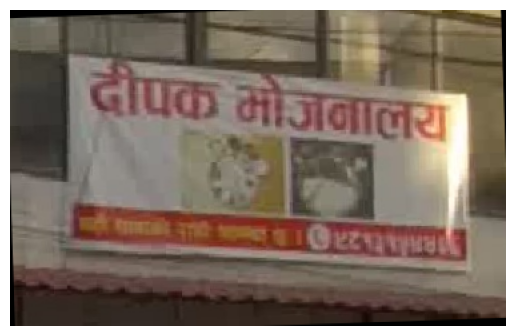

------------ Detected Text Regions ------------


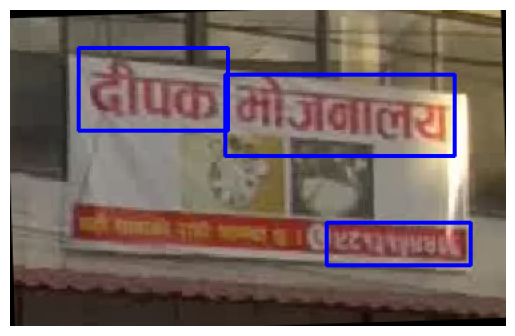

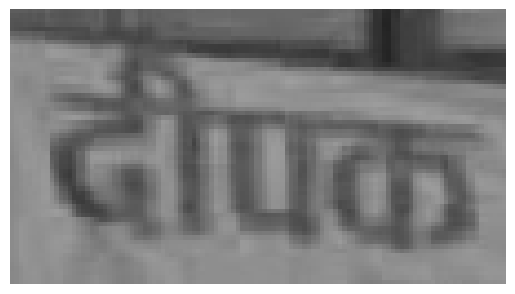

English (gray) : Qs

Nepali (gray) : दीपक

Nepali + Hindi (gray) : दीपक



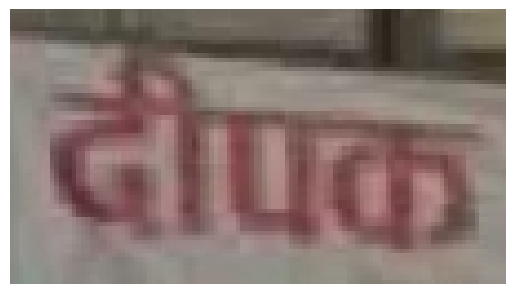

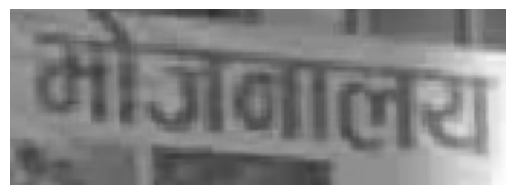

English (gray) : NI

Nepali (gray) : भोजलालरा

Nepali + Hindi (gray) : भोजलालरा



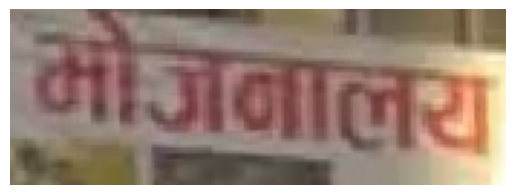

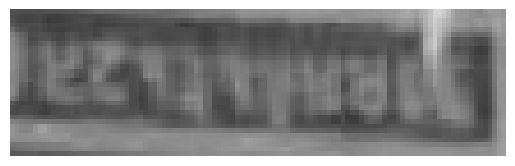

English (gray) : ’K!I‘Ei!

Nepali (gray) : 2470 4

Nepali + Hindi (gray) : 2470 4



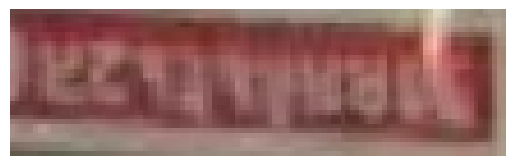

In [335]:
craft = Craft( crop_type="box", cuda=True,text_threshold=0.8,link_threshold=0.8,low_text=0.18)
img = cv2.imread('images/dipak.jpg')
CraftModule(craft,ocr).detect_text(img)